$$\Large \textbf{Loading Data}$$

-------

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tabulate import tabulate
import pandas as pd
import numpy as np
import pickle
import pandas
import copy
import cv2
import os

In [2]:
def pickle_read(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

def pickle_write(a, b):
    pickle_filename = a if len(a) >= 4 and a[-4:] == ".pkl" else b
    data = b if pickle_filename == a else a
    with open(pickle_filename, 'wb') as file:
        pickle.dump(data, file)

In [215]:
data_load = {
    "jar/InternVideo-a8.pkl": "IV_a8",
    "jar/InternVideo-a11.pkl": "IV_a11",
    "jar/CLIP-a.pkl": "CLIP_a",
    "jar/CLIP-r.pkl": "CLIP_r",
    "jar/CLIP-g.pkl": "CLIP_g",
    "jar/CLIP-g100.pkl": "CLIP_g100",
    "jar/InternVideo-r8.pkl": "IV_r8",
    "jar/InternVideo-r11.pkl": "IV_r11",
    "jar/InternVideo-r13.pkl": "IV_r13",
    "jar/InternVideo-a13.pkl": "IV_a13",
    "jar/InternVideo-r12.pkl": "IV_r12",
    "jar/InternVideo-a12.pkl": "IV_a12",
    "jar/InternVideo-r9.pkl": "IV_r9",
    "jar/InternVideo-a9.pkl": "IV_a9",
    "jar/InternVideo-a15.pkl": "IV_a15",
    "jar/InternVideo-r15.pkl": "IV_r15",
    "jar/InternVideo-a17.pkl": "IV_a17",
    "jar/InternVideo-r17.pkl": "IV_r17",
    "jar/InternVideo-r19.pkl": "IV_r19",
    "jar/InternVideo-a19.pkl": "IV_a19",
    "jar/InternVideo-g8.pkl": "IV_g8",
    "jar/InternVideo-g11.pkl": "IV_g11",
    "jar/InternVideo-g13.pkl": "IV_g13",
    "jar/InternVideo-g15.pkl": "IV_g15",
    "jar/InternVideo-g17.pkl": "IV_g17",
    "jar/InternVideo-g100.pkl": "IV_g100",
    "jar/InternVideo-a100.pkl": "IV_a100",
    "jar/InternVideo-r100.pkl": "IV_r100",
    "jar/XCLIP-r8.pkl": "XCLIP_r8",
    "jar/XCLIP-r11.pkl": "XCLIP_r11",
    "jar/XCLIPL-r8.pkl": "XCLIPL_r8",
    "jar/XCLIPL-r11.pkl": "XCLIPL_r11",
    "jar/XCLIPL-r13.pkl": "XCLIPL_r13",
    "jar/InternVideoSmall-r8.pkl": "IVS_r8",
    "jar/InternVideoSmall-r11.pkl": "IVS_r11",
    "jar/InternVideoSmall-r13.pkl": "IVS_r13",
    "jar/InternVideoSmall-a8.pkl": "IVS_a8",
    "jar/InternVideoSmall-a11.pkl": "IVS_a11",
    "jar/InternVideoSmall-a13.pkl": "IVS_a13",
    "jar/InternVideoSmall-a15.pkl": "IVS_a15",
    "jar/InternVideoSmall-a17.pkl": "IVS_a17",
    "jar/InternVideoSmall-a19.pkl": "IVS_a19",
    "jar/InternVideo2-r8.pkl": "IV2_r8",
    "jar/InternVideo2-r11.pkl": "IV2_r11",
    "jar/InternVideo2-r13.pkl": "IV2_r13",
    "jar/InternVideo2-r15.pkl": "IV2_r15",
    "jar/InternVideo2-r17.pkl": "IV2_r17",
    "jar/InternVideo2-r19.pkl": "IV2_r19",
}

for key, value in data_load.items():
    exec(f'{value} = pickle_read(\'{key}\')')

logits_r = pickle_read('rustyjar/InternVideo-logits-r.pkl')
logits_a = pickle_read('rustyjar/InternVideo-logits-a.pkl')
logits_g = pickle_read('rustyjar/InternVideo-logits-g.pkl')
logits_r_xclip = pickle_read('rustyjar/XCLIP-l-logits-r8.pkl')
logits_r_smol = pickle_read('rustyjar/IVS-logits-r.pkl')
logits_a_smol = pickle_read('rustyjar/IVS-logits-r.pkl')
logits_r2 = pickle_read('rustyjar/InternVideo2-logits-r.pkl')

raw_data = pandas.read_csv('anno_backflip.csv')
data_k600 = []
for index, row in raw_data.iterrows():
    data_k600.append((row['ID'], eval('[' + row['Frame(s)'] + ']')))

data_gif87 = pickle_read('rustyjar/GIF87.pkl')

print(len(IV_a8), 'predictions loaded.')
print("First 10 Predictions from Intern Video:      ", IV_a8[:10])
print("First 10 predictions from CLIP:              ", CLIP_a[:10])
print("-"*50)
print("First 10 actual values:", [x[1] for x in data_k600[:10]])

50 predictions loaded.
First 10 Predictions from Intern Video:       [269, 68, 217, 140, 177, 131, 52, 73, 63, 177]
First 10 predictions from CLIP:               [237, 76, 216, 72, 197, 16, 53, 90, 20, 180]
--------------------------------------------------
First 10 actual values: [[268], [67], [211], [137], [166], [107], [52], [65], [67], [180]]


In [214]:
def logitToPred(logit_lists, window_size = 8):
    result = []
    for logits in logit_lists:
        logits_c = copy.deepcopy(logits)
        logits_c.sort(key = lambda x: x[1])
        new_logits = []
        add = (window_size -8) // 2
        for j in range(add, len(logits_c) - add):
            a_range = list(range(j - add, j + add + 1))
            a_range = [logits_c[x][0] for x in a_range]
            new_logits.append((np.mean(a_range).item(), j + 1))
            # new_logits.append((logits_c[j][0], j + 1))
        # print(new_logits)
        # print("---"*10)
        # print(logits_c)
        new_logits.sort(key = lambda x: -x[0])
        if len(new_logits) == 0:
            new_logits.append((0, 4))
        result.append(new_logits[0][1])
    return result
# test = logitToPred(logits_a_smol, window_size = 13)
j = 11
while True:
    if j == 21: break
    pickle_write(logitToPred(logits_r2, window_size = j), f'jar/InternVideo2-r{j}.pkl')
    j += 2
# test = logitToPred(logits_g, window_size = 11)
# pickle_write(logitToPred(logits_g, window_size = 17), 'jar/InternVideo-g17.pkl')

$$\Large \textbf{Reading Logits and Averaging Predictions}$$

------

In [ ]:
IV_g100 = []
for idx, p11 in enumerate(IV_g11):
    p13 = IV_g13[idx]
    p15 = IV_g15[idx]
    IV_g100.append((p11+p13)//2)
pickle_write(IV_g100, 'jar/InternVideo-g100.pkl')

In [ ]:
correct = pickle_read('rustyjar/GIF87.pkl')
print(correct[-5:])

In [205]:
logits_r2

[[(np.float32(0.27739286), 1),
  (np.float32(0.2787647), 2),
  (np.float32(0.27571544), 3),
  (np.float32(0.2752447), 4),
  (np.float32(0.27555463), 5),
  (np.float32(0.27424154), 6),
  (np.float32(0.27511585), 7),
  (np.float32(0.27639303), 8),
  (np.float32(0.27617925), 9),
  (np.float32(0.27486193), 10),
  (np.float32(0.27478385), 11),
  (np.float32(0.27343866), 12),
  (np.float32(0.27545682), 13),
  (np.float32(0.27436104), 14),
  (np.float32(0.27420306), 15),
  (np.float32(0.2740836), 16),
  (np.float32(0.2748965), 17),
  (np.float32(0.27392852), 18),
  (np.float32(0.27537602), 19),
  (np.float32(0.2752933), 20),
  (np.float32(0.27572426), 21),
  (np.float32(0.27505976), 22),
  (np.float32(0.2749011), 23),
  (np.float32(0.2764206), 24),
  (np.float32(0.27552038), 25),
  (np.float32(0.27737293), 26),
  (np.float32(0.27816418), 27),
  (np.float32(0.27941516), 28),
  (np.float32(0.2790617), 29),
  (np.float32(0.2787972), 30),
  (np.float32(0.27723545), 31),
  (np.float32(0.27774167),

In [ ]:
IV_g13 = []
logits_37 = []
for idx, logits in enumerate(logits_g):
    logits_sort = copy.deepcopy(logits)

    avg_logits = []

    for i in range(2, len(logits) - 2):
        if idx == 37:
            logits_37.append((sum([logits[x][0] for x in [i - 2, i - 1, i, i + 1, i + 2]])/5, i + 1))
        avg_logits.append((sum([logits[x][0] for x in [i - 2, i - 1, i, i + 1, i + 2]])/5, i + 1))
    
    avg_logits.sort(key = lambda x: -x[0])
    IV_g13.append(avg_logits[0][1])
    

print(IV_g13[-5:])
pickle_write(IV_g13, 'jar/InternVideo-g13.pkl')

In [ ]:
print(IV_a100[38])
plt.figure(figsize=[3, 2])
plt.plot([x[1] for x in logits_a[38]], [x[0] for x in logits_a[38]], linewidth=2)
plt.xlabel("Frame Index")
plt.ylabel("Similarity Score")

plt.gca().set_position([0, 0, 1, 1])
plt.savefig('frame-similarity-score.svg', bbox_inches="tight")

plt.show()

$$\Large \mathbf{1}^{\text{st}}\text{ Metric}$$

--------

In [120]:
def showMetric(preds, data, threshold = 8, compare = False):
    def clamp_error(prediction, truth): # NN's Idea
        if truth in range(prediction, prediction + 9):
            return 0
        else: 
            return (prediction + 8) - truth if truth > prediction + 8 else prediction - truth
    
    score = 0
    offsets = []
    for idx, i_pred in enumerate(preds):
        within_range = False
        off = 10000
        for truth in data[idx][1]:
            if abs(i_pred - truth) < abs(off):
                off = i_pred - truth
    
            if abs(i_pred - truth) <= threshold:
                within_range = True
        
        if within_range:
            score += 1
    
        offsets.append(off)
    
    score = score / len(data)
    # print(f"Accuracy with |error| <= {threshold}:",'{}%'.format(round(score*100, 2)))

    return score

In [116]:
[[]] * 5

[[], [], [], [], []]

In [138]:
showMetric(eval('IVS_r13'), data_k600, threshold=2)

0.38

In [201]:
IV2_r8

[np.int64(274),
 np.int64(76),
 np.int64(222),
 np.int64(151),
 np.int64(163),
 np.int64(135),
 np.int64(60),
 np.int64(72),
 np.int64(71),
 np.int64(190),
 np.int64(291),
 np.int64(34),
 np.int64(122),
 np.int64(288),
 np.int64(79),
 np.int64(39),
 np.int64(76),
 np.int64(239),
 np.int64(293),
 np.int64(161),
 np.int64(18),
 np.int64(95),
 np.int64(157),
 np.int64(233),
 np.int64(243),
 np.int64(148),
 np.int64(78),
 np.int64(209),
 np.int64(68),
 np.int64(253),
 np.int64(186),
 np.int64(20),
 np.int64(151),
 np.int64(222),
 np.int64(83),
 np.int64(71),
 np.int64(90),
 np.int64(137),
 np.int64(33),
 np.int64(64),
 np.int64(155),
 np.int64(76),
 np.int64(31),
 np.int64(46),
 np.int64(77),
 np.int64(66),
 np.int64(93),
 np.int64(62),
 np.int64(43),
 np.int64(53)]

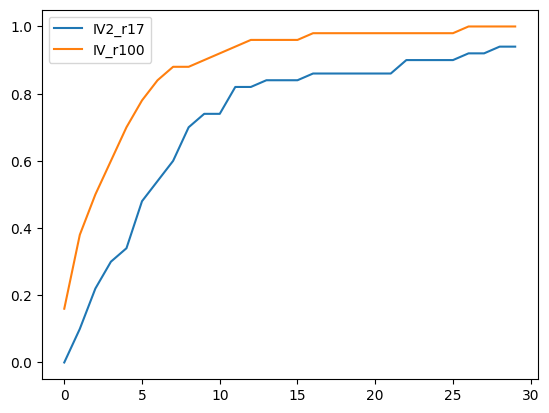

In [212]:
compare = "IV2_r17,IV_r100".split(',')

plot_data = eval(str([[]] * len(compare)))
for test_threshold in range(30):
    for idx, preds in enumerate(compare):
        plot_data[idx].append(showMetric(eval(preds), data_k600, threshold=test_threshold))

for i, j in enumerate(plot_data):
    plt.plot(j, label = compare[i])
plt.legend()
plt.show()

In [203]:
norm_scale = []
for video_path in tqdm([os.path.join('backflip', x) for x in os.listdir('backflip')]):
    cap = cv2.VideoCapture(video_path)

    frame_num = 0
    success, frame = cap.read()
    while success:
        frame_num += 1
        success, frame = cap.read()
    cap.release()
    
    norm_scale.append(1 / frame_num)

print(norm_scale[:5])

  0%|          | 0/50 [00:00<?, ?it/s]

[0.009433962264150943, 0.005128205128205128, 0.008264462809917356, 0.004784688995215311, 0.011363636363636364]


$$\Large \mathbf{2}^{\text{nd}}\text{ Metric}$$

--------

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# Find closest peak
def findClosest(pred, truths):
    dist = 1000000
    peak = -1
    for i in truths:
        if abs(i - pred) < dist:
            dist = abs(i - pred)
            peak = i
    return peak

def showMetric2(preds, data):
    def clamp_error(prediction, truth): # NN's Idea
        if truth in range(prediction, prediction + 9):
            return 0
        else: 
            return (prediction + 8) - truth if truth > prediction + 8 else prediction - truth
    
    mse = []
    for idx, i_pred in enumerate(preds):
        # peak = findClosest(i_pred, data[idx][1]) * norm_scale[idx]
        peak = findClosest(i_pred, data[idx][1])
        # mse.append(abs((i_pred * norm_scale[idx]) - peak)) # Calculating MAE??
        mse.append(abs(i_pred - peak)) # Calculating MAE??
    
    return mse

def find_best_offset(preds, data):
    total = []
    min_val = float('inf')
    min_result = -1
    for l in [x/100 for x in range(-3000, 3000, 1)]:
        mse = calculateMSE([x + l for x in preds], data)
        total.append((l, mse))
        if mse < min_val:
            min_val = mse
            min_result = l
    return min_result

def offset(preds, data):
    best_off = find_best_offset(preds, data)
    return [x + best_off for x in preds]

def calculateMSE(preds, data):
    errors = []
    for idx, i_pred in enumerate(preds):
        new_pred = i_pred + 0
        peak = findClosest(new_pred, data[idx][1])
        errors.append(abs(new_pred - peak)**2)
    return np.mean(errors).item()

In [264]:
data_k600[1]

(2, [67])

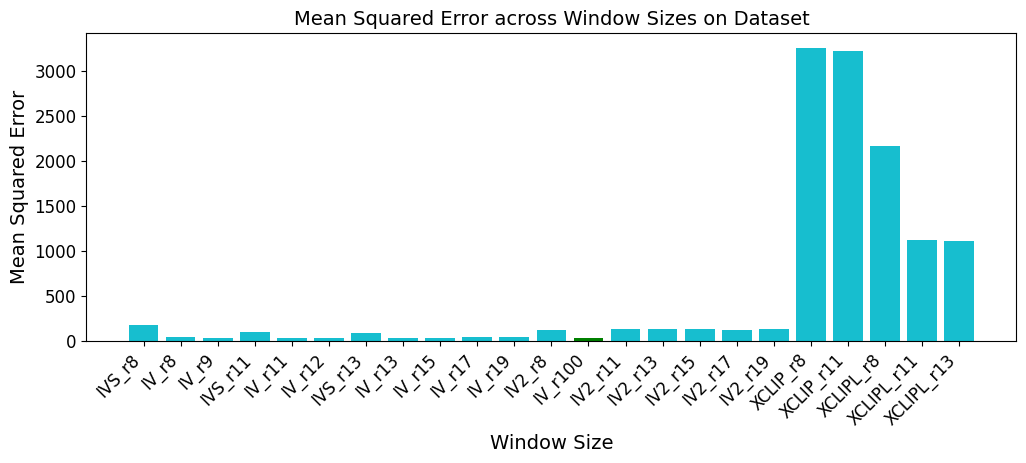

╒════╤════════════╤═══════════╤══════════╕
│    │ Model      │       MSE │   Offset │
╞════╪════════════╪═══════════╪══════════╡
│  0 │ IV_r100    │   36.8016 │     0.28 │
├────┼────────────┼───────────┼──────────┤
│  1 │ IV_r15     │   36.9076 │    -0.18 │
├────┼────────────┼───────────┼──────────┤
│  2 │ IV_r11     │   37.16   │     0    │
├────┼────────────┼───────────┼──────────┤
│  3 │ IV_r13     │   37.1764 │    -0.06 │
├────┼────────────┼───────────┼──────────┤
│  4 │ IV_r12     │   37.5684 │     0.54 │
├────┼────────────┼───────────┼──────────┤
│  5 │ IV_r9      │   40.4704 │     0.64 │
├────┼────────────┼───────────┼──────────┤
│  6 │ IV_r8      │   43.8484 │     0.46 │
├────┼────────────┼───────────┼──────────┤
│  7 │ IV_r19     │   45.4176 │     0.32 │
├────┼────────────┼───────────┼──────────┤
│  8 │ IV_r17     │   47.68   │     0.4  │
├────┼────────────┼───────────┼──────────┤
│  9 │ IVS_r13    │   94.0356 │     0.62 │
├────┼────────────┼───────────┼──────────┤
│ 10 │ IVS_

In [258]:
showCLIP = False
filter_vals = 'r'

data_use = data_gif87 if filter_vals == 'g' else data_k600

fig, ax = plt.subplots(figsize=(12, 4))

def extract_digits(input_string):
    digits = ''.join([char for char in input_string if char.isdigit()])
    return int(digits) if digits else 0

pred_labels = [x for x in (data_load.values() if showCLIP else filter(lambda x: not isCLIP(x), data_load.values()))]
pred_labels.sort(key=lambda x: (int(extract_digits(x)) if "IV" in x else 1000, x[3]))

if filter_vals != 'any':
    pred_labels = list(filter(lambda x: filter_vals in x, pred_labels))

predictions = [calculateMSE(offset(eval(x), data_use), data_use) for x in pred_labels]
pred_augment = [calculateMSE(offset(eval(x), data_use), data_use) for x in filter(lambda x: 'a' in x, pred_labels)]
best_mse = min(predictions)
best_augment_mse = min(pred_augment) if pred_augment else 0

def isCLIP(label):
    return 'CLIP' in label and 'XCLIP' not in label

def get_color(idx, x):
    if isCLIP(x):
        return 'tab:red'
    if predictions[idx] == best_mse:
        return 'green'
    elif predictions[idx] == best_augment_mse:
        return 'tab:cyan'
    else:
        if 'r' in x:
            return 'tab:cyan'
        else:
            return 'tab:cyan'

def get_name(x):
    if isCLIP(x): return x
    return x.split("_")[1][1:]

bar_colors = [get_color(idx, x) for idx, x in enumerate(pred_labels)]

ax.bar(pred_labels, predictions, label=pred_labels, color = bar_colors)

ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_xlabel('Window Size', fontsize=14)
ax.set_title('Mean Squared Error across Window Sizes on Dataset', fontsize=14)
# ax.legend(title='Model')
# ax.set_ylim(40, 73)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.xticks(rotation=45,ha = "right") 
plt.savefig("window_size_comparison.svg", bbox_inches="tight")
plt.show()

combined = list(zip(pred_labels, predictions))
combined.sort(key = lambda x: x[1])

df = pd.DataFrame({'Model': [x[0] for x in combined], 'MSE': [x[1] for x in combined], 'Offset': [find_best_offset(eval(x), data_use) for x in list(map(lambda x: x[0], combined))]})

print(tabulate(df, headers = 'keys', tablefmt = 'fancy_grid'))

# Window Size Plot
Line Graph of Window Size vs MSE

In [ ]:
pred_labels = [x for x in filter(lambda x: 'CLIP' not in x, data_load.values())]
pred_labels.sort(key=lambda x: (int(extract_digits(x)), x[3]))

augment_labels = list(filter(lambda x: 'a' in x and '100' not in x, pred_labels))
regular_labels = list(filter(lambda x: 'r' in x and '100' not in x, pred_labels))

plt.plot([extract_digits(x) for x in regular_labels], [calculateMSE(eval(x)) for x in regular_labels], linewidth=2)

plt.gca().set_position([0, 0, 1, 1])
plt.xlabel("Window Size")
plt.ylabel("Mean Squared Error")


plt.savefig("windowsize-mse-r.svg", bbox_inches = "tight")
plt.show()

In [25]:
data_k600[0]

(1, [268])

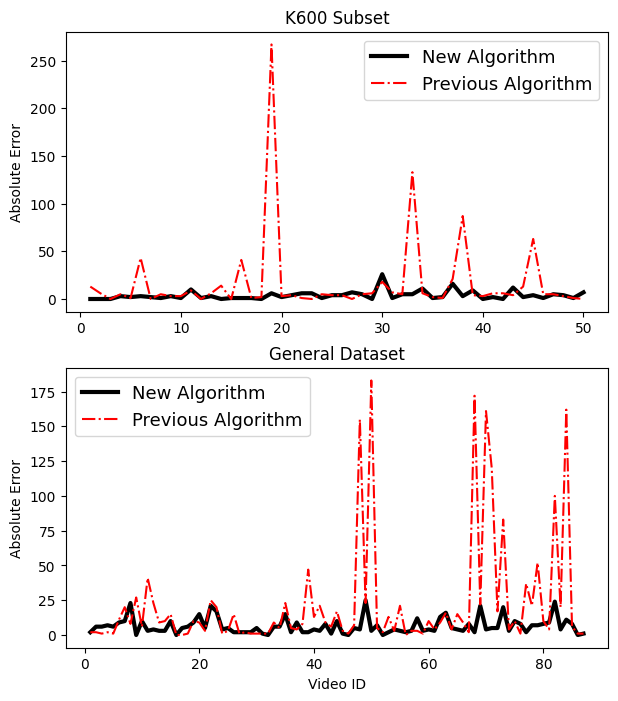

In [22]:
compare_g = 'IV_g13,CLIP_g'
compare_k = 'IV_r100,CLIP_r'

compare_g = [eval(x) for x in compare_g.split(',')]
compare_k = [eval(x) for x in compare_k.split(',')]

fig = plt.figure(figsize=[7, 8])

axs = fig.subplot_mosaic([["k600"],
                          ["gif87"]])

gif87 = axs["gif87"]

gif87.plot(range(1, len(data_gif87) + 1),showMetric2(compare_g[0], data_gif87), linewidth=3, color="black")
gif87.plot(range(1, len(data_gif87) + 1),showMetric2(compare_g[1], data_gif87), color="red", linestyle="dashdot")
gif87.set_ylabel("Absolute Error")
gif87.legend(["New Algorithm", "Previous Algorithm"], fontsize=13)
gif87.set_title("General Dataset")
gif87.set_xlabel("Video ID")

k600 = axs["k600"]

k600.plot(range(1, len(data_k600) + 1),showMetric2(compare_k[0], data_k600), linewidth=3, color="black")
k600.plot(range(1, len(data_k600) + 1),showMetric2(compare_k[1], data_k600), color="red", linestyle="dashdot")
k600.set_ylabel("Absolute Error")
k600.legend(["New Algorithm", "Previous Algorithm"], fontsize=13)
k600.set_title("K600 Subset")



# k600.gca().set_position([0, 0, 1, 1])
fig.savefig("general-data-compare.svg", bbox_inches = "tight")
plt.show()

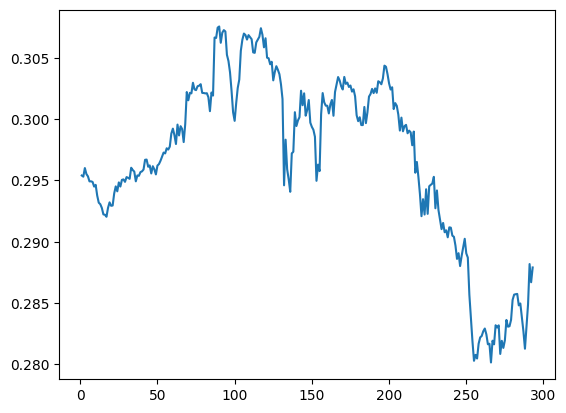

In [262]:
plt.plot([x[1] for x in logits_r2[36]], [x[0] for x in logits_r2[36]])
plt.show()

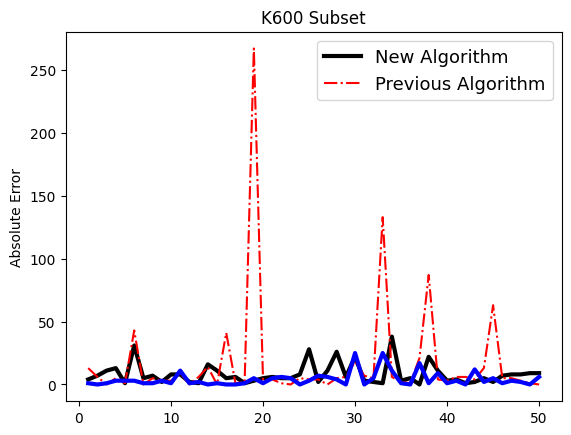

In [261]:
compare = 'IV2_r17,CLIP_r, IV_r17'

compare = [eval(x) for x in compare.split(',')]

fig = plt.figure()

axs = fig.subplot_mosaic([["k600"]])


k600 = axs["k600"]

k600.plot(range(1, len(data_k600) + 1),showMetric2(compare[0], data_k600), linewidth=3, color="black")
k600.plot(range(1, len(data_k600) + 1),showMetric2(compare[1], data_k600), color="red", linestyle="dashdot")
k600.plot(range(1, len(data_k600) + 1),showMetric2(compare[2], data_k600), linewidth=3, color="blue")
k600.set_ylabel("Absolute Error")
k600.legend(["New Algorithm", "Previous Algorithm"], fontsize=13)
k600.set_title("K600 Subset")



# k600.gca().set_position([0, 0, 1, 1])
fig.savefig("general-data-compare.svg", bbox_inches = "tight")
plt.show()

In [ ]:
def arenaMetric(model1, model2):
    exec(f"{model1}_score = 0")
    exec(f"{model2}_score = 0")
    tie_score = 0

    offsets = [find_best_offset(x) for x in [eval(model1), eval(model2)]]
    pred1, pred2 = [x + offsets[0] for x in eval(model1)], [x + offsets[1] for x in eval(model2)]
    
    for idx in range(len(pred1)):
        peak1 = findClosest(pred1[idx], data[idx][1])
        peak2 = findClosest(pred2[idx], data[idx][1])
        
        if abs(pred1[idx] - peak1) < abs(pred2[idx] - peak2):
            exec(f"{model1}_score += 1")
        elif abs(pred1[idx] - peak1) > abs(pred2[idx] - peak2):
            exec(f"{model2}_score += 1")
        else:
            tie_score += 1

    data_arena = pd.DataFrame({'': [model1, model2, 'Tied'], 'Score': [eval(f"{model1}_score"), eval(f"{model2}_score"), tie_score]})
    
    print(tabulate(data_arena, headers = 'keys', tablefmt = 'fancy_grid'))

arenaMetric('IV_g13', 'CLIP_g100')

In [ ]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import clear_output

def load_basketball(basketball_path, size):
    basketball = Image.open(basketball_path)
    basketball = basketball.resize((size, size), Image.LANCZOS)
    return basketball

def rotate_basketball(basketball):
    random_angle = np.random.randint(0, 360)
    return basketball.rotate(random_angle, expand=True)

def add_basketball_to_frame(frame, basketball):
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    basketball_rotated = rotate_basketball(basketball)

    frame_width, frame_height = frame_pil.size
    basketball_width, basketball_height = basketball_rotated.size

    max_x = frame_width - basketball_width
    max_y = frame_height - basketball_height
    rand_x = np.random.randint(0, max_x)
    rand_y = np.random.randint(0, max_y)

    frame_pil.paste(basketball_rotated, (rand_x, rand_y), basketball_rotated)
    return cv2.cvtColor(np.array(frame_pil), cv2.COLOR_RGB2BGR)

def process_video(input_video_path, output_video_path, basketball_path, basketball_size):
    basketball = load_basketball(basketball_path, basketball_size)
    cap = cv2.VideoCapture(input_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    count = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        count += 1
        clear_output(wait=True)
        frame_with_basketball = add_basketball_to_frame(frame, basketball)

        plt.title(str(count))
        plt.imshow(frame)
        plt.show()
        out.write(frame_with_basketball)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

input_video_path = 'augment/9.mp4'
output_video_path = 'augment/92.mp4'
basketball_path = 'augment_utils/cruise.png'
basketball_size = 1

process_video(input_video_path, output_video_path, basketball_path, basketball_size)

In [ ]:
import os
import shutil
from moviepy.editor import VideoFileClip

input_folder = 'gifs'
output_folder = 'GIF87'

os.makedirs(output_folder, exist_ok=True)

new_files = []
for filename in os.listdir(input_folder):
    file_path = os.path.join(input_folder, filename)
    
    if filename.endswith('.mp4'):
        shutil.copy(file_path, os.path.join(output_folder, filename))
        new_files.append(file_path)
    else:
        output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.mp4')
        clip = VideoFileClip(file_path)
        clip.write_videofile(output_path)
        clip.close()

In [ ]:
print(sorted([int(x.split('/')[-1].split('.')[0]) for x in new_files]))